<a href="https://colab.research.google.com/github/Nusserle/LieDetection/blob/master/LieDetectionEEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import scipy
from scipy import signal

import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics

plt.rcParams['figure.figsize'] = (18, 6)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Data Exploration

In [66]:
%cd drive/My Drive/Shared/BagOfLies/
df = pd.read_csv("Annotations.csv")
df_eeg = df[['eeg', 'truth']].dropna().reset_index()
df_eeg.head()

[Errno 2] No such file or directory: 'drive/My Drive/Shared/BagOfLies/'
/content/drive/My Drive/Shared/BagOfLies


,index,eeg,truth
0,0,./Finalised/User_0/run_0/EEG.csv,1
1,1,./Finalised/User_0/run_1/EEG.csv,0
2,2,./Finalised/User_0/run_2/EEG.csv,0
3,3,./Finalised/User_0/run_3/EEG.csv,0
4,4,./Finalised/User_0/run_4/EEG.csv,0


(array([ 2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  6.,  6.,  5.,  5.,
         5.,  7.,  4., 12.,  6., 15.,  8., 12.,  7.,  3.,  5.,  5., 12.,
         3.,  4.,  2.,  3.,  4.,  7.,  4.,  1.,  0.,  3.,  2.,  0.,  4.,
         1.,  2.,  4.,  1.,  2.,  1.,  4.,  0.,  1.,  0.,  1.,  0.,  1.,
         1.,  0.,  2.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,
         0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,
         1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  59.  ,  107.08,  155.16,  203.24,  251.32,  299.4 ,  347.48,
         395.56,  443.64,  491.72,  539.8 ,  587.88,  635.96,  684.04,
         732.12,  780.2 ,  828.28,  876.36,  924.44,  972.52, 1020.6 ,
        1068.68, 1116.76, 1164.84, 1212.92, 1261.  , 1309.08, 1357.16,
        1405.24, 1453.32, 1501.4 , 1549.48, 1597.56, 1645.64, 1693.72,
        1741.8 , 1789.88, 1837.96, 1886.04, 1934.12, 1982.2 , 2030.28,
        

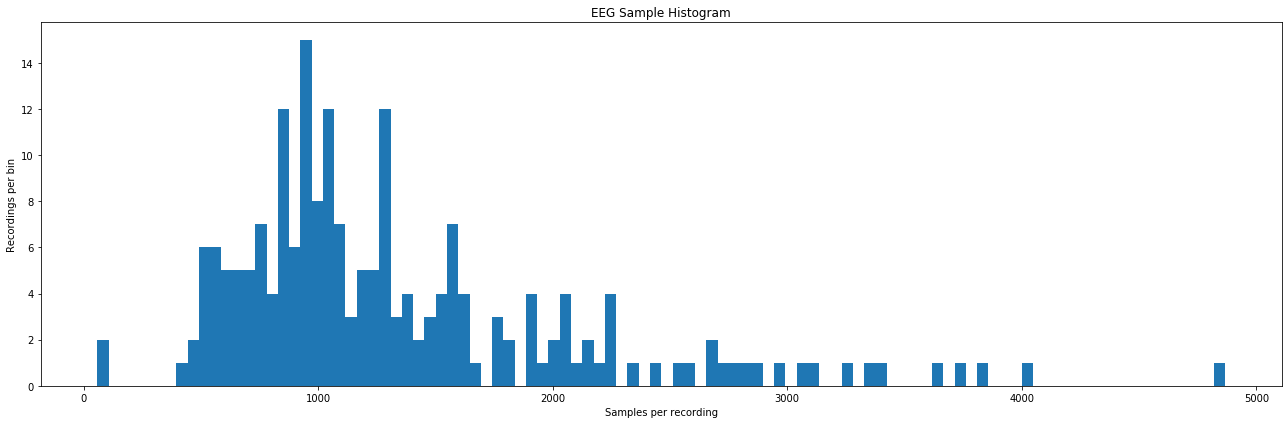

In [62]:
lengths = []
for i, eeg in df_eeg.iterrows():
  lengths.append(pd.read_csv(eeg[1]).iloc[:,1:-1].shape[0])
fig, axs = plt.subplots(tight_layout=True)
axs.set_title('EEG Sample Histogram')
axs.set_xlabel('Samples per recording')
axs.set_ylabel('Recordings per bin')
axs.hist(lengths, bins=100)


In [63]:
df_sample = pd.read_csv(df_eeg.iloc[2,:][1]).iloc[:,1:-1]
df_sample.head()

,F3 Value,F3 Quality,FC5 Value,5C5 Quality,F7 Value,F7 Quality,T7 Value,T7 Quality,P7 Value,P7 Quality,O1 Value,O1 Quality,O2 Value,O2 Quality,P8 Value,P8 Quality,T8 Value,T8 Quality,F8 Value,F8 Quality,AF4 Value,AF4 Quality,FC6 Value,FC6 Quality,F4 Value,F4 Quality,X Value,Y Value
0,-121,0,-127,0,-125,0,-64,0,-99,0,-117,0,-148,0,-120,0,-101,0,-100,4728,-112,0,-138,0,-83,0,21,24
1,-132,0,-124,0,-116,0,-154,0,-118,0,-123,0,-124,0,-139,0,-101,0,-125,4728,-112,0,-145,0,-73,0,22,24
2,-126,0,-122,0,-120,0,-149,0,-118,0,-119,0,-82,0,-131,0,-98,0,-110,4728,-105,0,-164,0,-79,0,22,24
3,-125,2064,-123,0,-123,0,-150,0,-128,0,-122,0,-119,0,-118,0,-101,0,-113,4728,-104,0,-134,0,-81,0,22,24
4,-127,2064,-126,24,-121,0,-151,0,-122,0,-121,0,-169,0,-125,0,-100,0,-118,4728,-117,0,-63,0,-84,0,22,24


In [64]:
df_filtered = df_sample.loc[:, df_sample.columns.str.contains('Value')]
df_filtered = df_filtered.iloc[:,:-2]
df_filtered.head()

,F3 Value,FC5 Value,F7 Value,T7 Value,P7 Value,O1 Value,O2 Value,P8 Value,T8 Value,F8 Value,AF4 Value,FC6 Value,F4 Value
0,-121,-127,-125,-64,-99,-117,-148,-120,-101,-100,-112,-138,-83
1,-132,-124,-116,-154,-118,-123,-124,-139,-101,-125,-112,-145,-73
2,-126,-122,-120,-149,-118,-119,-82,-131,-98,-110,-105,-164,-79
3,-125,-123,-123,-150,-128,-122,-119,-118,-101,-113,-104,-134,-81
4,-127,-126,-121,-151,-122,-121,-169,-125,-100,-118,-117,-63,-84


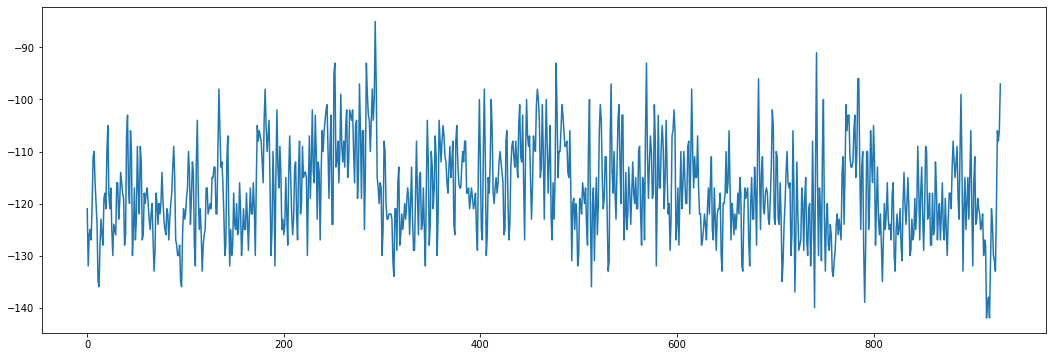

In [65]:
# EEG Signal from channel F3 with noise
f3_channel_eeg = df_filtered.iloc[:,:1]
plt.plot(f3_channel_eeg)

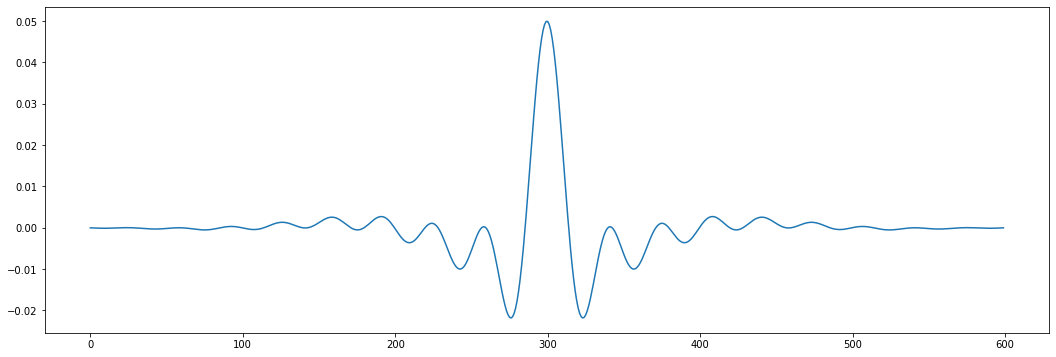

In [51]:
# Filter
filter = signal.firwin(600, [0.01, 0.06], pass_zero=False)
plt.plot(filter)
plt.show()

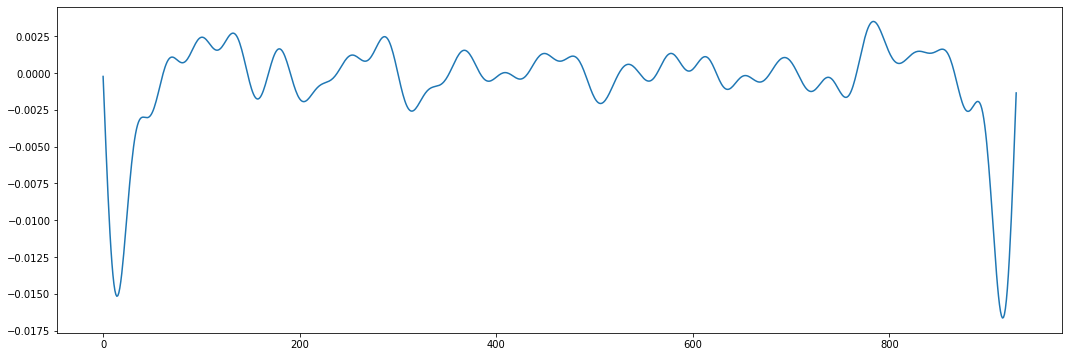

In [52]:
# Normalized values
data_norm_to_0_1 = [number/scipy.linalg.norm(f3_channel_eeg.squeeze()) for number in f3_channel_eeg.squeeze()]
# Applied filter to normalized signal
filtered_and_normalized = signal.convolve(data_norm_to_0_1, filter, mode="same")
plt.plot(filtered_and_normalized)

## Preprocessing

In [67]:
# Maximum length of all samples
current_max_dimension = 0
for i, eeg in df_eeg.iterrows():
  df_curr = pd.read_csv(eeg[1]).iloc[:,1:-1]
  if df_curr.shape[0] > current_max_dimension:
    current_max_dimension = df_curr.shape[0]
print(current_max_dimension)

4867


In [153]:
data = np.zeros((df_eeg.shape[0], current_max_dimension * sum(df_curr.columns.str.contains('Value'))))
print(data.shape)
label = []
for i, eeg in df_eeg.iterrows():
  if i % 20 == 0:
    print("Processed trials:", i)
  df_trial = pd.read_csv(eeg[1]).iloc[:,1:-1]
  # Convert to numeric and drop N/A values
  df_trial = df_trial.apply(lambda x: pd.to_numeric(x, errors = 'coerce')).dropna()
  # Filter EEG table only for values (except for X and Y Value)
  df_trial = df_trial.loc[:, df_trial.columns.str.contains('Value')]
  combined_vec = np.asarray([])
  for col in df_trial:
    # Normalize and filter
    data_norm_to_0_1 = [number/scipy.linalg.norm(df_trial[col].squeeze()) for number in df_trial[col].squeeze()]
    filtered_and_normalized = signal.convolve(data_norm_to_0_1, filter, mode="same")
    combined_vec = np.asarray(list(combined_vec) + list(filtered_and_normalized))
  for j, el in enumerate(combined_vec):
    data[i][j] = combined_vec[j]
  
  #min_max_scaler = preprocessing.MinMaxScaler()
  #x_scaled = min_max_scaler.fit_transform(x)
  
  label.append(eeg[2])
label = np.asarray(label)

(201, 73005)
Processed trials: 0
Processed trials: 20
Processed trials: 40
Processed trials: 60
Processed trials: 80
Processed trials: 100
Processed trials: 120
Processed trials: 140
Processed trials: 160
Processed trials: 180
Processed trials: 200


In [145]:
print(data.shape)
print(label.shape)

(201, 73005)
(201,)


In [146]:
print(data)

[[-107. -109. -119. ...    0.    0.    0.]
 [ -99. -117. -116. ...    0.    0.    0.]
 [-121. -132. -126. ...    0.    0.    0.]
 ...
 [-132. -125. -113. ...    0.    0.    0.]
 [-126. -113. -125. ...    0.    0.    0.]
 [-119. -129. -132. ...    0.    0.    0.]]


In [0]:
new_data = []
for el in data:
  new = el.flatten()
  new_data.append(new)
new_data = np.asarray(new_data)
print(new_data.shape)
data = new_data

(201, 4867)


In [0]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPClassifier

In [152]:
models = [svm.SVC(), KNeighborsClassifier(n_neighbors=5), GaussianNB(), DecisionTreeClassifier()]
models = [MLPClassifier()]
for model in models:
  accuracies = []
  kf = KFold(n_splits=7, shuffle=False)
  for train_index, test_index in kf.split(data):
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = label[train_index], label[test_index]
    learned = model.fit(X_train, y_train)
    prediction = learned.predict(X_test)
    score = accuracy_score(y_test, prediction)
    print(score)
    accuracies.append(score)
  print("Model {} with avg test accuracy: {}".format(model, sum(accuracies)/accuracies.__len__()))  

0.3793103448275862
0.5862068965517241
0.4827586206896552
0.4482758620689655
0.5172413793103449
0.6428571428571429
0.6785714285714286
Model MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False) with avg test accuracy: 0.5336030964109781


In [0]:
X_train = data[:150]
y_train = label[:150]
#X_val = data[120:150]
#y_val = label[120:150]
X_test = data[150:]
y_test = label[150:]

In [0]:

#dtc = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, verbose=1)
dtc = DecisionTreeClassifier()
dtc_model = dtc.fit(X_train, y_train)

In [109]:
preds = dtc_model.predict(X_test)
accuracy_score(y_test, preds)

0.5686274509803921

In [0]:
model = models.Sequential()
model.add(layers.Dense(73005, activation='relu' ,input_shape=(73005,)))
#model.add(layers.Dense(4869, activation='sigmoid'))
model.add(layers.Dense(20000, activation='relu'))
model.add(layers.Dense(1000, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(X_train,
                    y_train,
                    epochs=30,
                    batch_size=20,
                    validation_data=(X_val, y_val), verbose=1)

Train on 120 samples, validate on 30 samples
Epoch 1/30


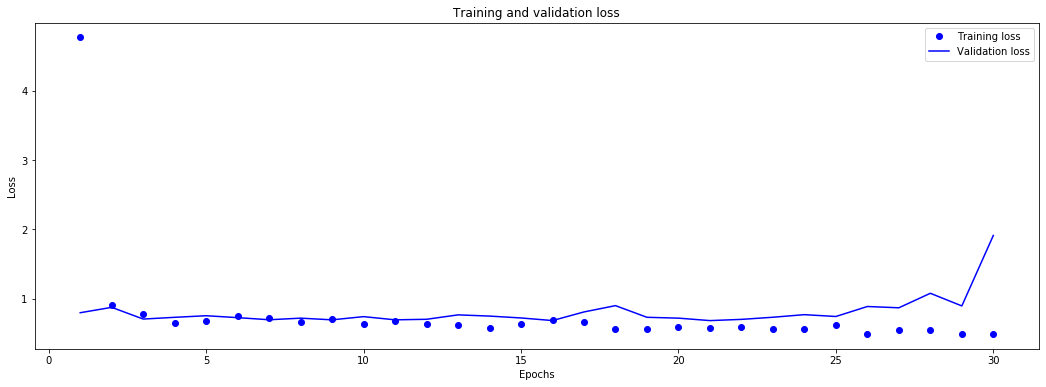

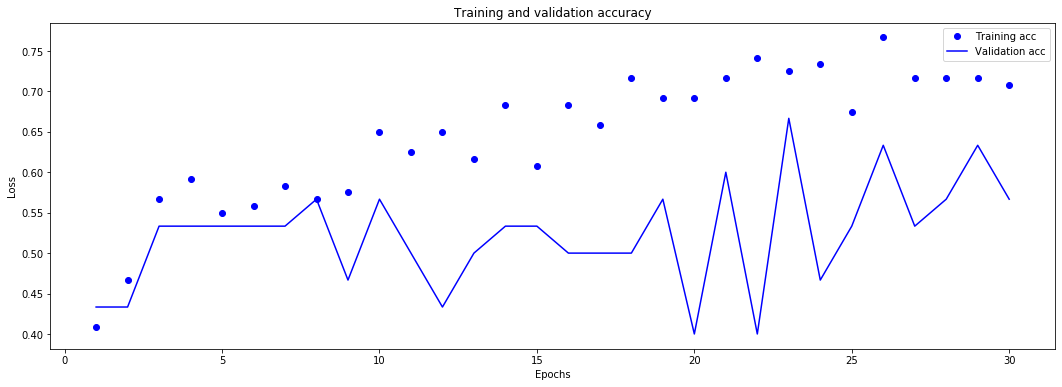

In [0]:
# Loss plot
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy plot
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(test_acc)

51/51 [==============================] - 0s 200us/step
0.45098039332558126


In [0]:
model2 = models.Sequential()
#model2.add(layers.LSTM(57, activation='tanh' ,input_shape=(57,300,)))
model2.add(layers.Dense(57, activation='relu' ,input_shape=(57,300,)))
#model.add(layers.Conv1D(64, 5, activation='relu',input_shape=(57,300,)))
#model.add(layers.GlobalMaxPooling1D())
#model.add(layers.GRU(64, activation='tanh', input_shape=(57,300,)))
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(38, activation='relu'))
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(16, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))
model2.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['acc'])